In [79]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV

data = pd.read_csv('datasets/purdue_2022.csv')
data.head()

,Playid,Gameid,Gamedate,Gameseason,Week,Gsisgamekey,Gsisplayid,Quarter,Down,Clock,...,Unblockedpressure,Vise,Wralignment1,Wralignment2,Wralignment3,Wralignment4,Unnamed: 180,Contested,Runpassoption,Playclock
0,4453436,21589,9/1/2022,2022,1,82512,37,1,0,15:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1,4453598,21589,9/1/2022,2022,1,82512,148,1,1,14:03,...,PAST D46 (R.A.S) LOLB,NaN,-14.5,-5.5,10.5,18.5,NaN,NaN,0,16.0
2,4453616,21589,9/1/2022,2022,1,82512,172,1,2,13:33,...,NaN,NaN,-16.5,-11.5,-6.5,16.5,NaN,NaN,1,19.0
3,4453648,21589,9/1/2022,2022,1,82512,196,1,1,13:06,...,NaN,NaN,-10.5,3.5,17.5,NaN,NaN,NaN,1,15.0
4,4453663,21589,9/1/2022,2022,1,82512,218,1,2,12:30,...,NaN,NaN,-1.5,3.5,13.5,NaN,NaN,1; PAST D09,0,10.0


In [82]:
dataframe = data[
            (data["Offpersonnelbasic"] != "Unknown")
            & (data["Offpersonnelbasic"] != "10 Men")
        ]

dataframe["Gainloss"] = dataframe["Gainloss"].replace(" ", np.nan, regex=True)

# created a new column that moved the yards gained or lost on a play down a row
dataframe["Yards on Previous Play"] = dataframe["Gainloss"].shift()
dataframe["previous_play"] = dataframe["Runpass"].shift()

dataframe = dataframe[(dataframe["Runpass"] == "R") | (dataframe["Runpass"] == "P")]
dataframe = dataframe[
    (dataframe["previous_play"] == "R") | (dataframe["previous_play"] == "P")
]

subset = dataframe[
        [
            "Quarter",
            "Minutes Left",
            "Down",
            "Distance",
            "Fieldposition",
            "Offpersonnelbasic",
            'Runpass',
            "Yards on Previous Play",
            "Scoredifferential",
            "previous_play",
        ]
    ]

cleaned_data = subset.dropna(
        subset=[
            "Quarter",
            "Minutes Left",
            "Down",
            "Distance",
            "Fieldposition",
            "Offpersonnelbasic",
            'Runpass',
            "Scoredifferential",
            "Yards on Previous Play",
            "previous_play",
        ]
    )

cleaned_data = cleaned_data.astype({"Yards on Previous Play": "int", 'Minutes Left': "int", "Quarter": "int"})


cleaned_data_w_dummies = pd.get_dummies(cleaned_data, columns=["previous_play", "Offpersonnelbasic"])

predictors = cleaned_data_w_dummies.columns.drop(['Runpass'])
target = 'Runpass'


train_data, test_data, train_sln, test_sln = train_test_split(
    cleaned_data_w_dummies[predictors],
    cleaned_data_w_dummies[target],
    test_size=0.3,
    random_state=0,
)

/tmp/ipykernel_11874/3899844391.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["Gainloss"] = dataframe["Gainloss"].replace(" ", np.nan, regex=True)
/tmp/ipykernel_11874/3899844391.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["Yards on Previous Play"] = dataframe["Gainloss"].shift()
/tmp/ipykernel_11874/3899844391.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

ValueError: Expected 2D array, got 1D array instead:
array=['11' '10 (*)' '10 (*)' '11' '11' '21' '11' '1' '11' '12' '11' '11' '12'
 '11' '11' '11' '11' '11' '11' '11' '2' '11 (*)' '11' '11' '11' '11' '11'
 '11' '11' '11 (*)' '11' '11' '11' '11' '22' '12' '11' '11' '11' '11' '11'
 '11' '11' '11' '10 (*)' '11' '11' '11' '11' '11' '11' '11' '11' '11' '21'
 '1' '1' '12' '20' '12' '11 (*)' '11' '11' '12' '0' '11' '11' '11' '11'
 '10 (*)' '21' '11' '11' '11' '11' '11' '11' '11' '12' '11' '11' '12' '11'
 '11' '11 (*)' '11' '21 (*)' '11' '11' '11' '11' '11' '12' '21' '21' '12'
 '10' '10' '21' '21' '11' '11' '11' '11' '11' '11' '11' '12' '11' '12'
 '11' '11' '11' '21' '1' '20' '11 (*)' '12' '11' '11' '11' '1' '11' '11'
 '12' '0' '11 (*)' '11' '12' '1' '1' '1' '12' '11' '11' '11' '11' '11'
 '11' '11' '11' '11 (**)' '11 (**)' '11' '11' '1' '11' '11' '11' '11' '12'
 '11' '11' '12' '2' '2' '12' '11' '11' '11' '11' '11' '11' '11' '11' '11'
 '11' '11' '11' '11' '1' '10' '11' '1' '1' '2' '11' '11 (*)' '11 (*)'
 '11 (*)' '11' '11' '12' '1' '11 (**)' '11' '11' '11' '11' '11' '11' '21'
 '12' '1' '11' '2' '11' '11 (*)' '11' '11' '11' '11' '11' '11' '11' '11'
 '11' '11' '11' '1' '11' '11' '11 (*)' '11 (*)' '11 (*)' '11 (*)' '11 (*)'
 '11 (*)' '21 (*)' '21 (*)' '11' '11' '11' '2' '11' '11' '11' '11' '11'
 '11' '11 (*)' '11' '10' '21' '21' '11' '11' '21' '12' '11 (*)' '11' '10'
 '2' '1' '1' '1' '11' '1' '11' '12' '10' '11' '11' '11' '11' '11' '11'
 '11' '1' '20' '11' '11' '11' '11' '11' '1' '21 (*)' '11' '11 (*)' '21'
 '11' '2' '1' '11' '11' '11' '11' '11' '12' '12' '11' '21' '11' '11' '11'
 '11' '11' '12' '12' '22 (*)' '11' '11' '11' '12' '11' '2' '11' '11'
 '11 (*)' '11' '11' '11' '11' '11' '11' '11' '11' '11' '11' '11' '11' '11'
 '11 (*)' '21' '12' '21' '11' '12' '12' '11' '11' '11' '11' '12' '12' '12'
 '21 (*)' '22' '11' '10' '11' '12' '2' '11' '11' '11' '11' '11' '11'
 '11 (*)' '21 (*)' '11' '11' '11' '11' '11' '11' '11' '11' '11' '11' '11'
 '11' '11' '11' '11' '11' '11' '11' '11' '21 (*)' '12' '11' '11' '11' '11'
 '11' '11' '11' '11' '11' '10' '12' '12' '12' '11' '12' '12' '11' '11'
 '11' '11' '11' '21 (*)' '12' '11' '11' '11' '11' '12' '12' '11' '10' '12'
 '11' '11' '11' '11' '11' '12' '21 (*)' '21 (*)' '21 (*)' '11' '1' '21'
 '1' '11' '12' '12' '11' '11' '11' '11' '11' '11' '11' '21' '11' '21' '11'
 '11' '11' '11' '21' '11' '11' '11' '12' '11' '10' '11' '11' '11' '11'
 '11' '11' '11' '11' '12' '12' '12' '11' '11' '11' '11' '12 (*)' '12 (*)'
 '12 (*)' '11' '11' '11' '11' '11' '11' '11' '11' '10' '10' '10' '11' '10'
 '12' '11' '10' '21' '11' '11' '12' '11' '10' '11' '11' '11' '12' '11'
 '22 (*)' '11' '11' '11' '11' '11' '12' '11' '12' '11' '11' '0' '11'
 '22 (*)' '21' '11' '11' '11' '11' '11' '12' '11' '11' '11' '11' '11' '11'
 '11' '11' '11' '11' '11' '11' '0' '11' '11' '12' '11' '11' '11' '11' '11'
 '11' '11' '11' '11' '11' '11' '11' '11' '11' '21' '11' '11' '12' '12'
 '12' '11' '11' '21' '11' '11' '12' '21' '21' '22 (*)' '12' '21 (*)' '11'
 '12' '11' '11' '10' '12' '12' '21' '11' '11' '11' '11 (*)' '11 (*)' '11'
 '11' '11' '12' '10' '11 (*)' '11' '12' '11' '11' '22 (*)' '12' '11' '11'
 '11' '11' '12' '21 (*)' '11' '11' '11' '12' '11' '21' '21' '12' '11'
 '11 (*)' '11' '11' '11' '11' '11' '11 (*)' '11' '11' '11' '11' '12' '11'
 '10 (*)' '11' '11' '11' '11' '12' '12' '11' '11' '22 (*)' '10 (*)' '12'
 '11' '11' '11' '12' '10' '2' '11' '11' '11' '2' '11' '11' '11' '11' '11'
 '10' '12' '11' '12' '12' '12' '12' '11' '11' '11' '12' '12' '12' '11'
 '12' '11' '11' '12' '22 (*)' '12' '2' '11' '12' '12' '11' '11' '12' '11'
 '11' '21 (*)' '11' '11' '11' '11' '11' '11' '11' '11' '11' '11' '11' '11'
 '11' '12' '11' '11' '11' '11' '11' '11' '11' '11' '11' '11' '12' '11'
 '11' '11' '22' '12' '11' '11' '11' '11' '11' '11' '11' '11' '12' '11'
 '11' '11' '11' '11' '10' '10' '11' '10' '11' '11' '11' '11' '11' '11'
 '11' '11' '11' '11' '11' '10' '11' '12' '11' '11' '11' '11' '11' '11'
 '11' '12' '11' '11' '2' '2' '11' '11' '11' '11' '11 (*)' '21' '1' '1' '1'
 '1' '2' '1' '11' '1' '1' '11' '2' '2' '11' '11' '11' '11' '11' '11' '11'
 '0'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [70]:
from statistics import mean
m = []
oob_error_rate = []


for i in range(1,len(cleaned_data_w_dummies.columns)):
    forest = RandomForestClassifier(random_state=0, n_estimators=1000, max_features=i, oob_score=True)
    forest.fit(train_data, train_sln)

    m.append(i)
    oob_error_rate.append(1 - forest.oob_score_)

min(oob_error_rate)

0.27324478178368117

In [71]:
print(oob_error_rate.index(min(oob_error_rate))+1)

19


In [72]:
from sklearn.metrics import roc_auc_score, roc_curve

forest = RandomForestClassifier(random_state=0, n_estimators=1000, max_features=(oob_error_rate.index(min(oob_error_rate))+1), oob_score=True)
forest.fit(train_data, train_sln)

prediction_prob = forest.predict_proba(test_data)[:, -1]
auc = roc_auc_score(test_sln, prediction_prob)
fpr, tpr, thresholds = roc_curve(test_sln, prediction_prob, pos_label="P")

print(forest.oob_score_)
print(auc)

0.7267552182163188
0.6793853314074788


In [73]:
# calculates J stat, combines J stat and thresholds lists, sorts the values in descending order then gets first post
optimal_proba_cutoff = sorted(list(zip(np.abs(tpr - fpr), thresholds)), key=lambda i: i[0], reverse=True)[0][1] 
roc_predictions = ["R" if i >= optimal_proba_cutoff else "P" for i in prediction_prob]

optimal_proba_cutoff

0.47

In [74]:
print(f"accuracy_score before threshold change: {accuracy_score(test_sln, forest.predict(test_data))}")
print(f"accuracy_score before threshold change: {accuracy_score(test_sln, roc_predictions)}")

accuracy_score before threshold change: 0.6475770925110133
accuracy_score before threshold change: 0.6696035242290749


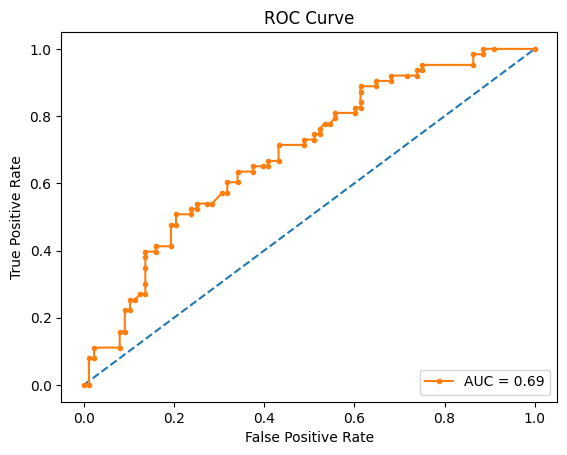

In [63]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot([0,1], [0,1], linestyle="--") # plot random curve
plt.plot(tpr, fpr, marker=".", label=f"AUC = {round(roc_auc_score(test_sln, prediction_prob), 2)}")
plt.title("ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")

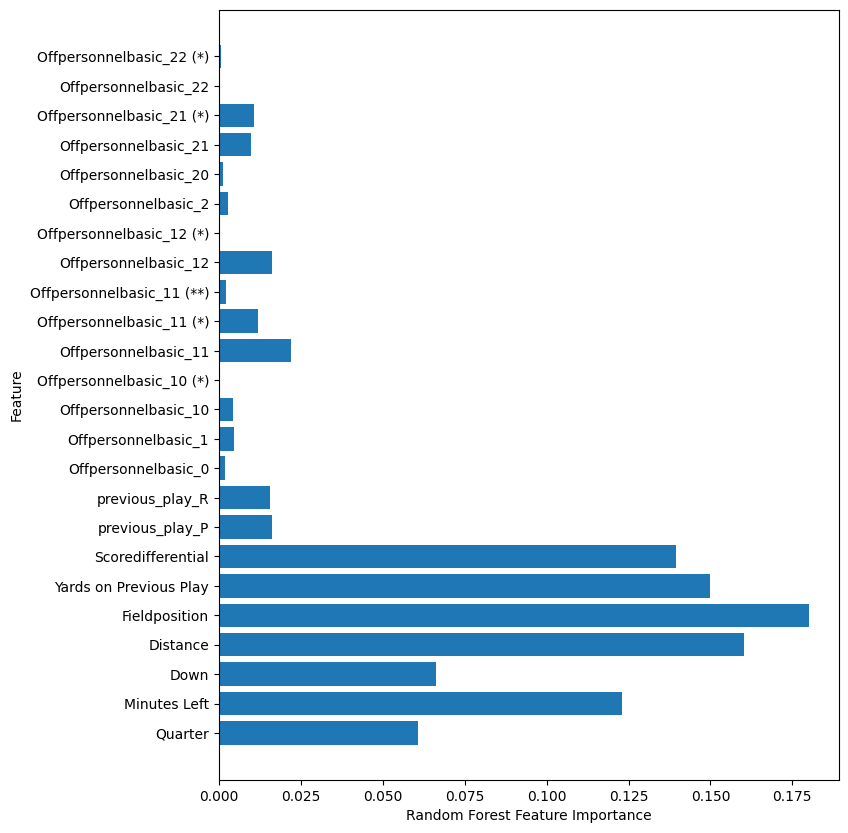

In [76]:
index = range(len(predictors))

plt.figure(figsize=(8,10)) 
plt.barh(index,forest.feature_importances_,height=0.8)
plt.ylabel('Feature')
plt.yticks(index,predictors) 
plt.xlabel("Random Forest Feature Importance")
plt.show()

In [42]:
from scipy.stats import truncnorm

model_params = {
    'n_estimators': list(range(50,500,50)),
    'max_features': list(range(1, len(cleaned_data_w_dummies.columns))),
    'min_samples_split': list(range(2,15)),
    'max_depth': list(range(1,30)),
    'min_samples_leaf': list(range(1,15))
}

opt = BayesSearchCV(
    RandomForestClassifier(random_state=0),
    search_spaces=model_params,
    n_iter=10,
    cv=5,
    return_train_score=True,
    scoring="roc_auc",
    random_state=0
)

opt.fit(train_data, train_sln)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(test_data, test_sln))
print("parameters: %s" % opt.best_estimator_.get_params())

val. score: 0.7179606519367157
test score: 0.6550207039337475
parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 13, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [36]:
from random import randint, uniform
from scipy.stats import truncnorm

model_params = {
    'n_estimators': list(range(50,500,50)),
    'max_features': list(range(1, len(cleaned_data_w_dummies.columns))),
    'min_samples_split': list(range(2,15)),
    'max_depth': list(range(1,30)),
    'min_samples_leaf': list(range(1,15))
}

clf = RandomizedSearchCV(RandomForestClassifier(random_state=0), model_params, n_iter=5, cv=5, random_state=1)


model = clf.fit(train_data, train_sln)
print(model.best_estimator_.get_params())
print(model.best_score_)
print(model.score(test_data, test_sln))

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 7, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
0.6761010101010101
0.608


In [51]:
#creating deepcopy of default parameters before manipulations
from copy import deepcopy
from time import time

from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from skopt import BayesSearchCV
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

pd.set_option('mode.chained_assignment', None)

results_dict = {}

le = LabelEncoder()
le.fit(train_sln)
labeled = le.transform(train_sln)
labeled_test = le.transform(test_sln)


#setting grid of selected parameters for iteration
params = {'gamma': [0,0.1,0.2,0.4],
            'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3],
            'max_depth': np.arange(start=1, stop=30, step=1, dtype='int32'),
            'n_estimators': np.arange(start=50, stop=150, step=25, dtype='int32'),
            'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7],
            'min_child_weight': np.arange(start=1, stop=7, step=1),
            'subsample': np.arange(start=0.5, stop=1.1, step=0.1)}
xgbc = xgb.XGBClassifier(objective='binary:logistic', booster="gbtree", eval_metric='auc', tree_method='hist', grow_policy='lossguide', random_state=0)

clf = BayesSearchCV(estimator=xgbc, search_spaces=params, scoring='roc_auc', return_train_score=True, cv=3, n_jobs=-1, n_iter=10, random_state=0)
clf.fit(train_data, labeled.ravel())

train_predictions = clf.predict(train_data)
test_predictions = clf.predict(test_data)

train_accuracy = accuracy_score(train_sln, le.inverse_transform(train_predictions))
test_accuracy = accuracy_score(test_sln, le.inverse_transform(test_predictions))


#best parameters
bp = clf.best_params_


print(f"train accuracy {train_accuracy}")
print(f"test accuracy {test_accuracy}")
print(bp)

print(f"best roc_auc score: {clf.best_score_}")
print(f"test roc_auc score: {clf.score(test_data, labeled_test)}")
print(f"parameters: {clf.best_estimator_.get_params()}" )

train accuracy 0.9014084507042254
test accuracy 0.616
OrderedDict([('colsample_bytree', 0.5), ('gamma', 0.0), ('learning_rate', 0.06), ('max_depth', 6), ('min_child_weight', 2), ('n_estimators', 75), ('subsample', 0.8999999999999999)])
best roc_auc score: 0.7026043940055288
test roc_auc score: 0.629399585921325
parameters: {'objective': 'binary:logistic', 'base_score': None, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'auc', 'feature_types': None, 'gamma': 0.0, 'grow_policy': 'lossguide', 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.06, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': 2, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 75, 'n_jobs': None, 